In [22]:
import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py

from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error

from nilearn import image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from nilearn.image import resample_to_img, math_img, new_img_like

import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nnt_data

from surfplot import Plot

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


## function

In [2]:
from nilearn import image, plotting
from surfplot import Plot
from neuromaps.transforms import fsaverage_to_fslr
import glob

def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    fig.show()

# Example usage:
# TST = (left_hemisphere_data, right_hemisphere_data)
# plot_brain_surfaces(TST, cbar_label='gradient', cmap='viridis', color_range=(0, .15))


# Multiclass clssification using sklearn
1. Classify pain, vicarious, cognitive maps based on single trials 
2. Classify pain, vicarious, cogntiive maps based on contrast maps

In [4]:
current_dir = os.getcwd()
current_dir
main_dir = Path(current_dir).parents[1]

# pipeline for multiclass
* load single trials
* Parcellate 
* save data into array with metadaa
* apply crossvalidation on data

In [42]:
singletrial_dir = '/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/'
# sub = "sub-0101"
subdirectories = glob.glob(join(singletrial_dir, "sub-*"))
flists = []
for subdir in subdirectories:
    sub = os.path.basename(subdir)
    flist = glob.glob(join(singletrial_dir, sub, f"{sub}_ses-*_run-*_runtype-*_event-stimulus_trial-*_cuetype-*_stimintensity-*.nii.gz"))
    flists.append(flist)

flattened_list = [item for sublist in flists for item in sublist]


In [50]:
flattened_list[0]

'/Volumes/spacetop_projects_cue/analysis/fmri/nilearn/singletrial_rampupdown/sub-0117/sub-0117_ses-01_run-02_runtype-cognitive_event-stimulus_trial-006_cuetype-low_stimintensity-med.nii.gz'

# run only once - extract parcel value from roi

In [51]:
# schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
# parcelarray = []
# metadata = []
# for fname in flattened_list:
#     metadata.append(os.path.basename(fname))
#     singletrialFSLR = neuromaps.transforms.mni152_to_fslr(fname, fslr_density='32k', method='linear')
#     parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
#     singletrial_parc = parc.fit_transform(singletrialFSLR, 'fsLR')
#     parcelarray.append(singletrial_parc)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-

In [54]:
# parcel_value = np.vstack(parcelarray)

In [77]:
# np.save('/Volumes/seagate/cue_singletrials/singletrial-pvc_atlas-schaefer2018.npy',parcel_value)

# data = {
#     "code_generated": "scripts/step12_multiclass/multiclass_parcels.ipynb",
#     "code_parcellate": """schaefer = nntdata.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
#                         parcelarray = []
#                         metadata = []
#                         for fname in flattened_list:
#                             metadata.append(os.path.basename(fname))
#                             singletrialFSLR = neuromaps.transforms.mni152_to_fslr(fname, fslr_density='32k', method='linear')
#                             parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')
#                             singletrial_parc = parc.fit_transform(singletrialFSLR, 'fsLR')
#                             parcelarray.append(singletrial_parc)""",
#     "atlas": "Schaefer2018_400Parcels_7Networks_order",
#     "python_packages": ["neuromaps", "netneurotools"]
# }
# with open('/Volumes/seagate/cue_singletrials/singletrial-pvc_atlas-schaefer2018.json', 'w') as json_file:
#     json.dump(data, json_file, indent=4)

In [73]:
# metadatadf = pd.DataFrame(metadata, columns=['filename'])

# df_split = metadatadf['filename'].str.extract(
#     r'(?P<sub>sub-\d+)_ses-(?P<ses>\d+)_run-(?P<run>\d+)_runtype-(?P<runtype>\w+)_event-(?P<event>\w+)_trial-(?P<trial>\d+)_cuetype-(?P<cuetype>\w+)_stimintensity-(?P<stimintensity>\w+)'
# )

# df_final = pd.concat([metadatadf, df_split], axis=1)
# df_final.head()
# df_final.to_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial-pvc_atlas-schaefer2018.tsv'), sep='\t', index=False, header=True)


filename       sub ses run  \
0  sub-0117_ses-01_run-02_runtype-cognitive_event...  sub-0117  01  02   
1  sub-0117_ses-01_run-05_runtype-cognitive_event...  sub-0117  01  05   
2  sub-0117_ses-01_run-05_runtype-cognitive_event...  sub-0117  01  05   
3  sub-0117_ses-01_run-06_runtype-vicarious_event...  sub-0117  01  06   
4  sub-0117_ses-01_run-01_runtype-vicarious_event...  sub-0117  01  01   

     runtype     event trial cuetype stimintensity  
0  cognitive  stimulus   006     low           med  
1  cognitive  stimulus   010    high           med  
2  cognitive  stimulus   001    high           low  
3  vicarious  stimulus   004     low           low  
4  vicarious  stimulus   004    high          high

In [165]:
metadata

['sub-0117_ses-01_run-02_runtype-cognitive_event-stimulus_trial-006_cuetype-low_stimintensity-med.nii.gz',
 'sub-0117_ses-01_run-05_runtype-cognitive_event-stimulus_trial-010_cuetype-high_stimintensity-med.nii.gz',
 'sub-0117_ses-01_run-05_runtype-cognitive_event-stimulus_trial-001_cuetype-high_stimintensity-low.nii.gz',
 'sub-0117_ses-01_run-06_runtype-vicarious_event-stimulus_trial-004_cuetype-low_stimintensity-low.nii.gz',
 'sub-0117_ses-01_run-01_runtype-vicarious_event-stimulus_trial-004_cuetype-high_stimintensity-high.nii.gz',
 'sub-0117_ses-01_run-01_runtype-vicarious_event-stimulus_trial-000_cuetype-low_stimintensity-med.nii.gz',
 'sub-0117_ses-01_run-06_runtype-vicarious_event-stimulus_trial-002_cuetype-high_stimintensity-low.nii.gz',
 'sub-0117_ses-01_run-05_runtype-cognitive_event-stimulus_trial-003_cuetype-high_stimintensity-med.nii.gz',
 'sub-0117_ses-01_run-02_runtype-cognitive_event-stimulus_trial-004_cuetype-low_stimintensity-low.nii.gz',
 'sub-0117_ses-01_run-03_runtyp

# load data (MUST)

In [5]:
parcel_value = np.load(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial-pvc_atlas-schaefer2018.npy'))
print(f"the shape of the parcel data {parcel_value.shape}")
df_final = pd.read_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial-pvc_atlas-schaefer2018.tsv'), sep='\t')

schaefer = nnt_data.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


the shape of the parcel data (20029, 400)


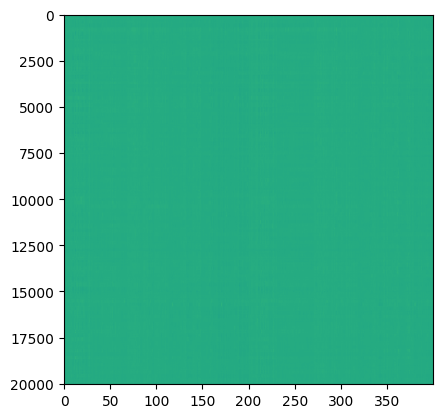

In [6]:
plt.imshow(parcel_value, aspect=.02, cmap='viridis')

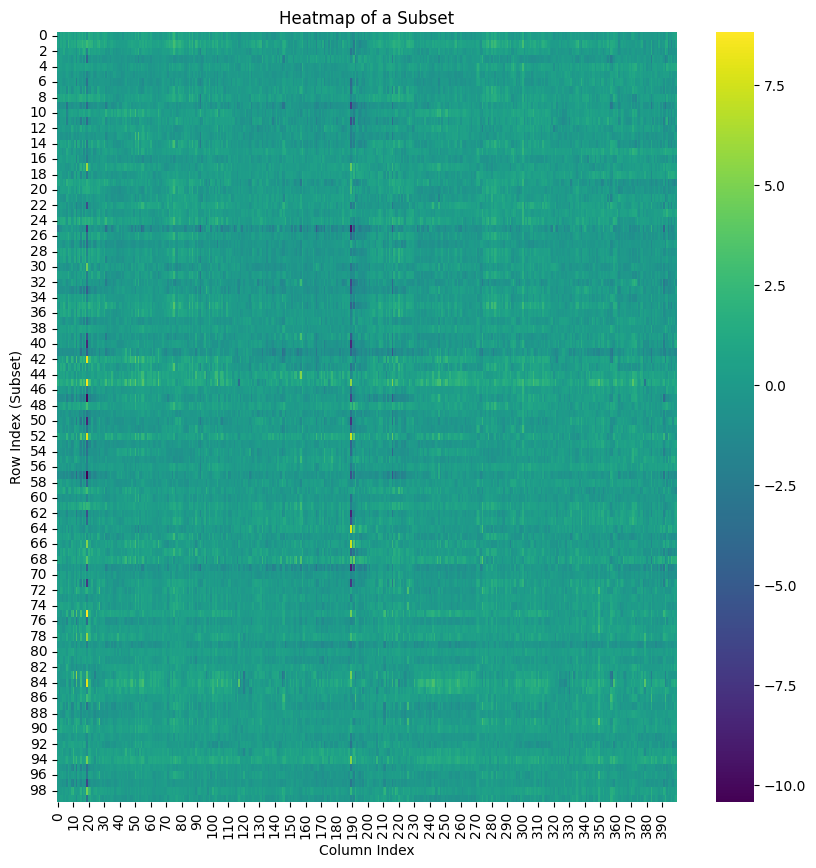

In [7]:
import seaborn as sns

# Selecting a subset (e.g., first 100 rows)
subset = parcel_value[:100, :]

plt.figure(figsize=(10, 10))
sns.heatmap(subset, cmap='viridis', cbar=True)
plt.title('Heatmap of a Subset')
plt.xlabel('Column Index')
plt.ylabel('Row Index (Subset)')
plt.show()


In [8]:
df_final

filename       sub  ses  run  \
0      sub-0117_ses-01_run-02_runtype-cognitive_event...  sub-0117    1    2   
1      sub-0117_ses-01_run-05_runtype-cognitive_event...  sub-0117    1    5   
2      sub-0117_ses-01_run-05_runtype-cognitive_event...  sub-0117    1    5   
3      sub-0117_ses-01_run-06_runtype-vicarious_event...  sub-0117    1    6   
4      sub-0117_ses-01_run-01_runtype-vicarious_event...  sub-0117    1    1   
...                                                  ...       ...  ...  ...   
20024  sub-0111_ses-04_run-06_runtype-pain_event-stim...  sub-0111    4    6   
20025  sub-0111_ses-03_run-05_runtype-vicarious_event...  sub-0111    3    5   
20026  sub-0111_ses-03_run-03_runtype-cognitive_event...  sub-0111    3    3   
20027  sub-0111_ses-04_run-03_runtype-cognitive_event...  sub-0111    4    3   
20028  sub-0111_ses-04_run-04_runtype-cognitive_event...  sub-0111    4    4   

         runtype     event  trial cuetype stimintensity  groupsinterim  
0      cognitive  stimulus      6     low           med              1  
1      cognitive  stimulus     10    high           med              1  
2      cognitive  stimulus      1    high           low              1  
3      vicarious  stimulus      4     low           low              1  
4      vicarious  stimulus      4    high          high              1  
...          ...       ...    ...     ...           ...            ...  
20024       pain  stimulus      7    high          high            112  
20025  vicarious  stimulus      0    high           med            112  
20026  cognitive  stimulus     10     low           low            112  
20027  cognitive  stimulus      9     low           med            112  
20028  cognitive  stimulus      3    high           low            112  

[20029 rows x 10 columns]

In [30]:
groups = df_final['groupsinterim']
df_final['task_cue'] = df_final['runtype'] +'_cue-' + df_final['cuetype']
Yinterim, uniques = pd.factorize(df_final['task_cue'])
X = parcel_value
Y = Yinterim

In [31]:
uniques

Index(['cognitive_cue-low', 'cognitive_cue-high', 'vicarious_cue-low',
       'vicarious_cue-high', 'pain_cue-high', 'pain_cue-low'],
      dtype='object')

In [14]:
min_class_size = np.bincount(Y).min()

# balancer
some participants don't have equal number of trials
we balance it here

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GroupKFold
from sklearn.utils import resample

# Given variables: X (data array), Y (factorized labels), groups (array of group labels)

# Convert groups to an array if it's not already
groups_array = np.array(groups)

# Find unique groups
unique_groups = np.unique(groups_array)

# Initialize lists to hold the balanced dataset
X_balanced = []
Y_balanced = []
groups_balanced = []

for group in unique_groups:
    # print(group)
    # Indices for the current group
    group_indices = np.where(groups_array == group)[0]
    print(group)
    # Extract current group's data and labels
    X_group = X[group_indices]
    Y_group = Y[group_indices]
    
    # Get the smallest class size within this group
    min_class_size = min(np.bincount(Y_group).min(), group_indices.size)
    if min_class_size > 0:
        # Initialize temporary lists for the group's balanced data
        X_group_balanced = []
        Y_group_balanced = []
        
        # Balance each class within the group
        for class_label in np.unique(Y_group):
            # print(class_label)
            # Indices for the current class within the group
            class_indices = np.where(Y_group == class_label)[0]
            
            # Resample the class to the target size
            resampled_indices = resample(class_indices, n_samples=min_class_size, replace=False, random_state=42)
            
            # Append resampled data and labels to the group's temporary lists
            X_group_balanced.append(X_group[resampled_indices])
            Y_group_balanced.append(Y_group[resampled_indices])
        
        # Concatenate balanced data for the current group and append to the overall balanced lists
        X_balanced.append(np.vstack(X_group_balanced))
        Y_balanced.append(np.concatenate(Y_group_balanced))
        groups_balanced += [group] * min_class_size * len(np.unique(Y_group))
    else:
        print("f{group} does not have trials in one of the classes")

# Concatenate all balanced data from each group to form the final balanced dataset
X_balanced = np.vstack(X_balanced)
Y_balanced = np.concatenate(Y_balanced)
groups_balanced = np.array(groups_balanced)

# Now, X_balanced, Y_balanced, and groups_balanced contain your balanced dataset respecting the original group structure


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
f{group} does not have trials in one of the classes
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112


In [16]:
# Check frequency of balanced data

# 1) Count the number of Y values per group
unique_groups = np.unique(groups_balanced)
group_counts = {group: np.bincount(Y_balanced[groups_balanced == group], minlength=len(np.unique(Y_balanced))) for group in unique_groups}

# 2) Convert to DataFrame for nicer display
df_group_counts = pd.DataFrame(group_counts, index=[f'Class {i}' for i in range(len(np.unique(Y_balanced)))])

df_group_counts


1    2    3    4    5    6    7    8    9    10   ...  103  104  105  \
Class 0   12   36   36   36   32   36   30   12   30   24  ...   24   36   12   
Class 1   12   36   36   36   32   36   30   12   30   24  ...   24   36   12   
Class 2   12   36   36   36   32   36   30   12   30   24  ...   24   36   12   
Class 3   12   36   36   36   32   36   30   12   30   24  ...   24   36   12   
Class 4   12   36   36   36   32   36   30   12   30   24  ...   24   36   12   
Class 5   12   36   36   36   32   36   30   12   30   24  ...   24   36   12   

         106  107  108  109  110  111  112  
Class 0   24   30   24   36   36   30   18  
Class 1   24   30   24   36   36   30   18  
Class 2   24   30   24   36   36   30   18  
Class 3   24   30   24   36   36   30   18  
Class 4   24   30   24   36   36   30   18  
Class 5   24   30   24   36   36   30   18  

[6 rows x 111 columns]

# SVM (classification)

In [17]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier to evaluate the model's performance on the given brain data and labels, ensuring that the cross-validation process is stratified and group-wise. The mean accuracy provides an estimate of how well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting the labels on the test data.
# accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []

# Loop through each fold

import time
start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
y_pred_probas = []
y_tests = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced, Y_balanced, groups_balanced)):
    X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
    Y_train, Y_test = Y_balanced[train_idx], Y_balanced[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    weights = svm.coef_
    weights_per_fold.append(weights)
    y_tests.append(Y_test)
# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 49.88%
Elapsed time: 1106.1414943920026 seconds


In [18]:
accuracies

[0.5064102564102564,
 0.4893162393162393,
 0.5010683760683761,
 0.4820261437908497,
 0.4989106753812636,
 0.5213675213675214,
 0.5205627705627706,
 0.48664529914529914,
 0.49296536796536794,
 0.48856209150326796]

In [32]:
uniques

Index(['cognitive_cue-low', 'cognitive_cue-high', 'vicarious_cue-low',
       'vicarious_cue-high', 'pain_cue-high', 'pain_cue-low'],
      dtype='object')

## SVM-1. Confusion matrix

In [33]:
original_class_names = np.array(uniques)
# The desired order for the classes
desired_class_order = ['pain_cue-low', 'pain_cue-high',
                       'vicarious_cue-low','vicarious_cue-high',
                       'cognitive_cue-low', 'cognitive_cue-high'
                        ]


# Create a dictionary that maps the original indices to the desired class order
class_mapping = {np.where(uniques == name)[0][0]: desired_index
                 for desired_index, name in enumerate(desired_class_order)}


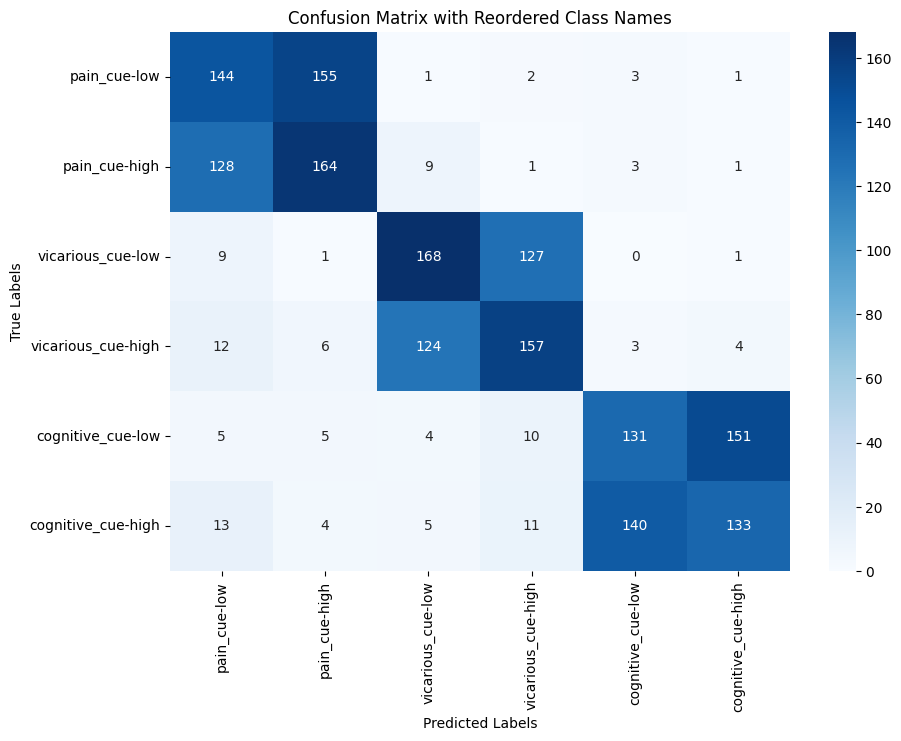

In [34]:
cm = confusion_matrix(Y_test, Y_pred)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')
plt.show()

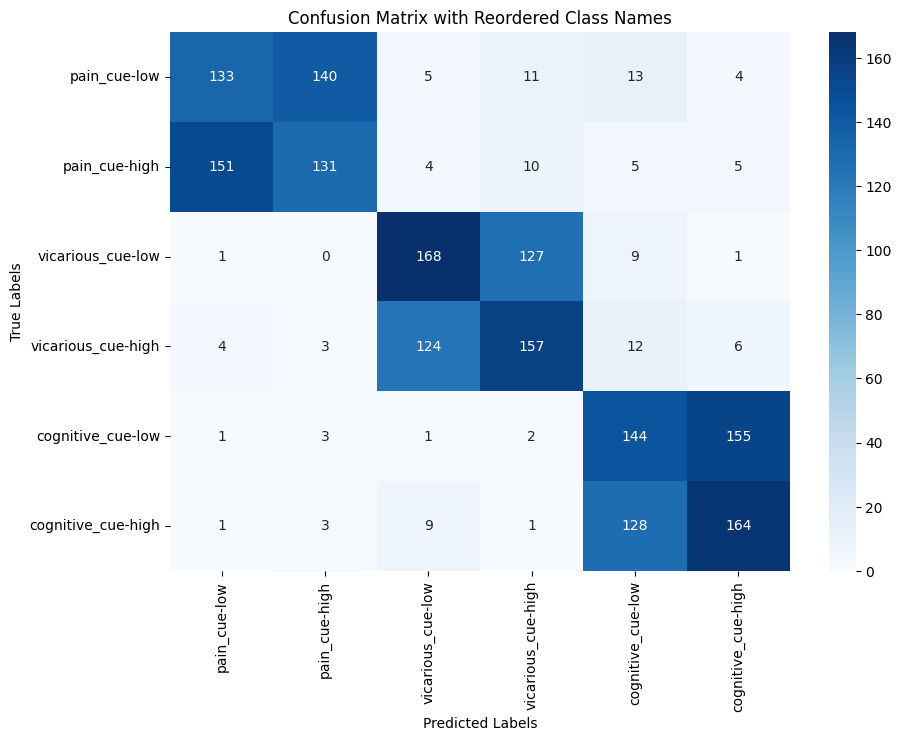

In [35]:


Y_test_remapped = np.vectorize(class_mapping.get)(Y_test)
Y_pred_remapped = np.vectorize(class_mapping.get)(Y_pred)

# Compute the confusion matrix using the remapped labels
cm = confusion_matrix(Y_test_remapped, Y_pred_remapped)

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')
plt.show()

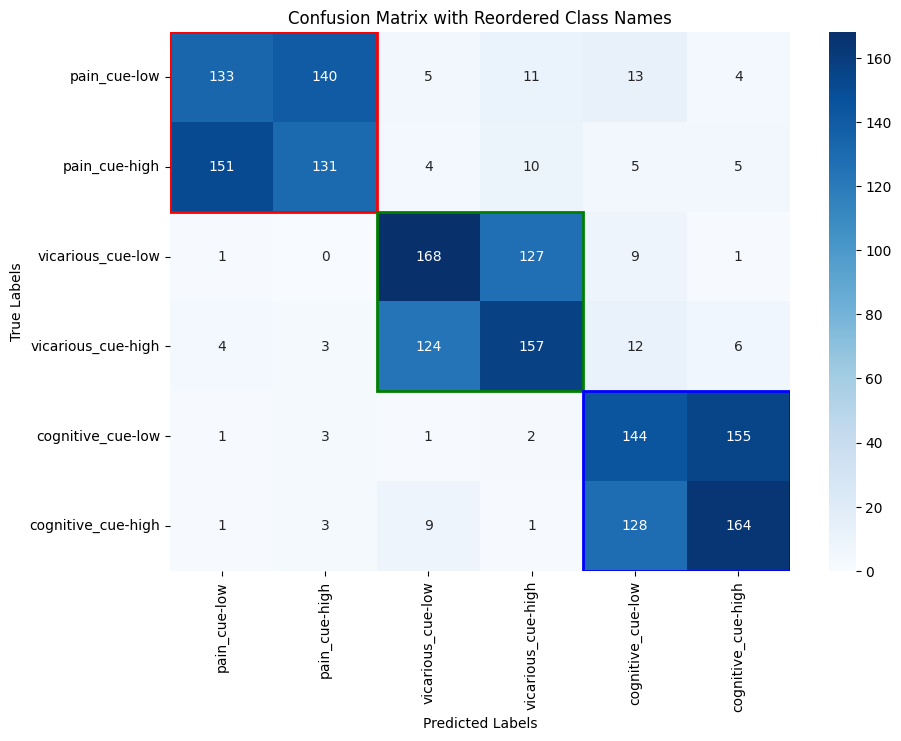

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Assuming cm, desired_class_order, and plotting code as before

# Plotting the confusion matrix with class labels in the desired order
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=desired_class_order, yticklabels=desired_class_order)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')

# Example for adding color blocks to distinguish sections
# Add rectangles for pain (red), vicarious (green), cognitive (blue)
# Assuming the order and counts of the classes are known (3 pain, 3 vicarious, 3 cognitive)
class_counts = [2, 2, 2]  # Number of classes in each category
colors = ['red', 'green', 'blue']  # Colors for each category
start_idx = 0

for count, color in zip(class_counts, colors):
    end_idx = start_idx + count
    # Add rectangle for the true labels
    ax.add_patch(Rectangle((start_idx, start_idx), count, count, fill=False, edgecolor=color, lw=2))
    # Update start index for next section
    start_idx = end_idx

plt.show()


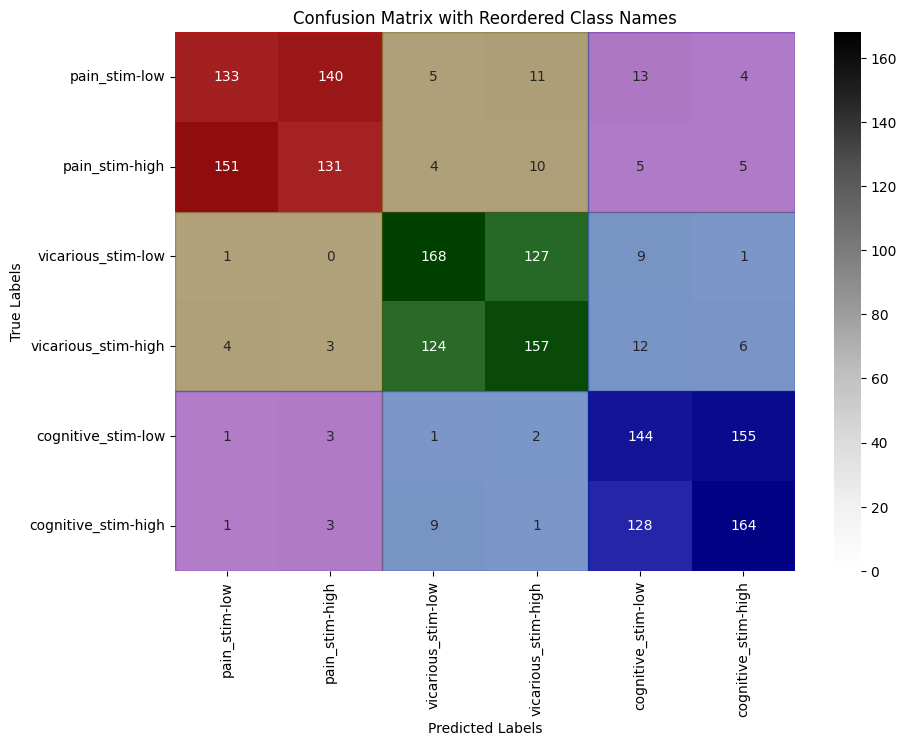

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming Y_test_remapped, Y_pred_remapped, cm, and desired_class_order are defined as before

# Define the start and end indices for each category in the desired_class_order
# Assuming there are 3 classes for pain, 3 for vicarious, and 3 for cognitive in the order provided
category_indices = {
    'pain': (0, 2),
    'vicarious': (2, 4),
    'cognitive': (4, 6)
}

# Colors for each category
category_colors = {
    'pain': 'red',
    'vicarious': 'green',
    'cognitive': 'blue'
}

# Plotting the confusion matrix with class labels in the desired order
fig, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Grays", xticklabels=desired_class_order, yticklabels=desired_class_order, ax=ax)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix with Reordered Class Names')

# Add color blocks on the edges of y and x axis
for category, (start_idx, end_idx) in category_indices.items():
    color = category_colors[category]
    # Add spans for the y-axis
    ax.axhspan(start_idx, end_idx, color=color, alpha=0.3)
    # Add spans for the x-axis
    ax.axvspan(start_idx, end_idx, color=color, alpha=0.3)

plt.show()


## SVM-2. roc curve

In [39]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier 
# to evaluate the model's performance on the given brain data and labels, 
# ensuring that the cross-validation process is stratified and group-wise. 
# The mean accuracy provides an estimate of how well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting the labels on the test data.
# accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []

# Loop through each fold

import time
start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
# scores = []
# weights_per_fold = []
# coefficients = []
# yloadings = []
# y_pred_probas = []
# y_tests = []
roc_y_true = []
roc_y_proba = []
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X_balanced, Y_balanced, groups_balanced)):
    roc_X_train, roc_X_test = X_balanced[train_idx], X_balanced[test_idx]
    roc_Y_train, roc_Y_test = Y_balanced[train_idx], Y_balanced[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    roc_svm = SVC(kernel='linear', decision_function_shape='ovr', probability=True)  # One-vs-Rest
    roc_svm.fit(roc_X_train, roc_Y_train)
    
    # Predict using the trained model
    Y_pred_proba = roc_svm.predict_proba(roc_X_test)
    y_pred_probas.append(Y_pred_proba)
    # Store the true labels and probabilities
    roc_y_true.extend(roc_Y_test)
    roc_y_proba.extend(Y_pred_proba)

end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

roc_np_y_true = np.array(roc_y_true)
roc_np_y_proba = np.array(roc_y_proba)



Elapsed time: 7270.174243005 seconds


In [ ]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt

# # Calculate ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# num_classes = len(np.unique(Y_balanced))

# for i in range(num_classes):
#     fpr[i], tpr[i], _ = roc_curve(roc_np_y_true == i, roc_np_y_proba[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])



# # Plot ROC curves for each class
# plt.figure()
# colors = ['blue', 'skyblue', 'purple', 'red','magenta', 'maroon', 'lightgreen', 'yellow', 'green']  # Adjust colors as needed
# for i in range(num_classes):
#     plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {uniques[i]} (AUC = {roc_auc[i]:.2f})')

# plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc='lower right')
# plt.show()


## SVM-3. plotting weigthmaps

In [39]:
uniques

Index(['cognitive_cue-low', 'cognitive_cue-high', 'vicarious_cue-low',
       'vicarious_cue-high', 'pain_cue-high', 'pain_cue-low'],
      dtype='object')

In [40]:

cog_low = parc.inverse_transform(weights_per_fold[0][0])
cog_high = parc.inverse_transform(weights_per_fold[0][1])
vic_low = parc.inverse_transform(weights_per_fold[0][2])
vic_high = parc.inverse_transform(weights_per_fold[0][3])
pain_high = parc.inverse_transform(weights_per_fold[0][4])
pain_low = parc.inverse_transform(weights_per_fold[0][5])


In [125]:
# hm_viridis_onesided = LinearSegmentedColormap.from_list('homemade_viridis_one_side', (
#     # Edit this gradient at https://eltos.github.io/gradient/#homemade_viridis_one_side=E62D4F-3648A6-42A7CB-4D9421-E0DB1E
#     (0.000, (0.902, 0.176, 0.310)),
#     (0.250, (0.212, 0.282, 0.651)),
#     (0.500, (0.259, 0.655, 0.796)),
#     (0.750, (0.302, 0.580, 0.129)),
#     (1.000, (0.878, 0.859, 0.118))))

(<nibabel.gifti.gifti.GiftiImage at 0x1657c3e50>,
 <nibabel.gifti.gifti.GiftiImage at 0x16574c790>)

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown

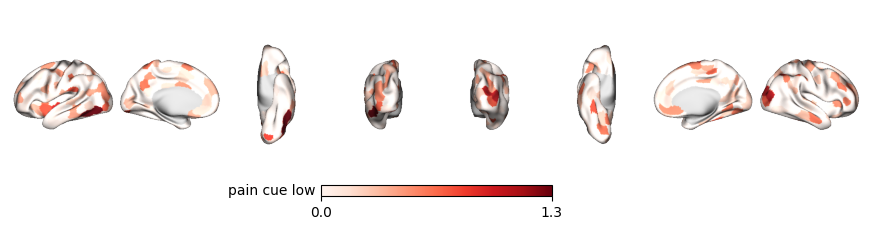

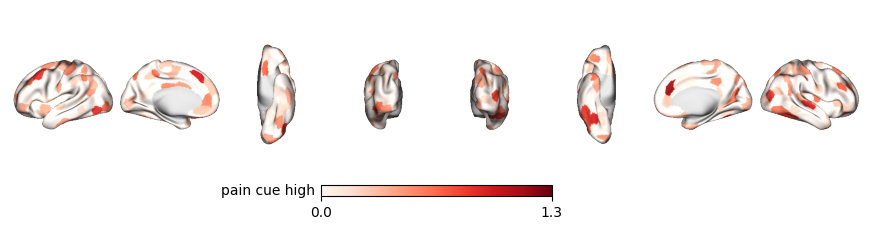

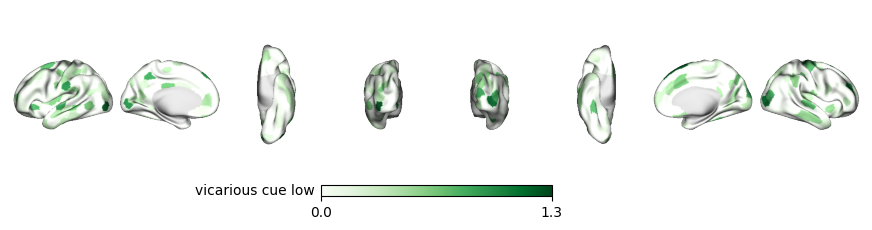

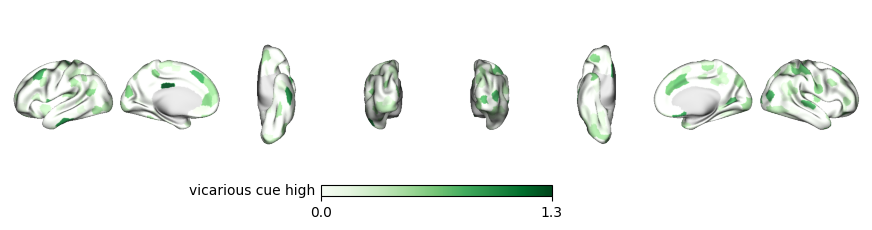

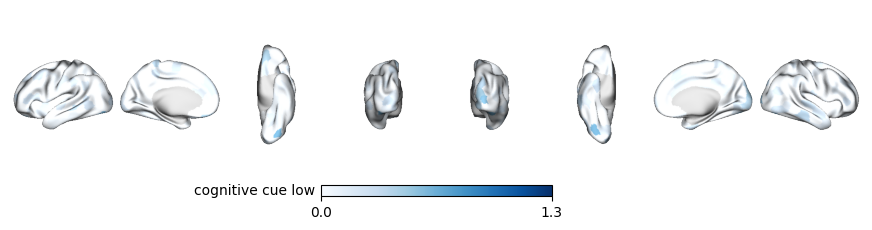

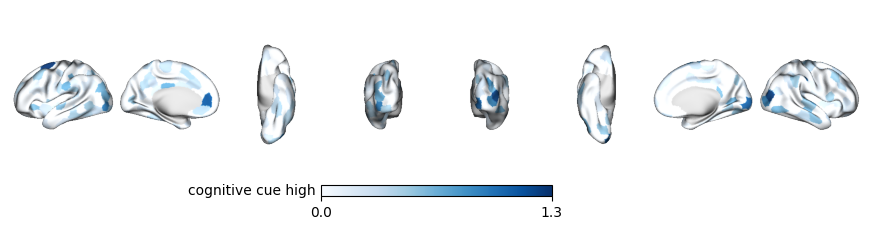

In [56]:
# Assuming 'weights_original_space' is the weights projected back to the original space



# Use this value to define the color range centered around zero
color_range = (-max_abs_weight, max_abs_weight)
color_range = (0,1.3)
plot_brain_surfaces(image=pain_low, cbar_label='pain cue low', cmap='Reds', color_range=color_range)

plot_brain_surfaces(image=pain_high, cbar_label='pain cue high', cmap='Reds', color_range=color_range)

plot_brain_surfaces(image=vic_low, cbar_label='vicarious cue low', cmap='Greens',  color_range=color_range)

plot_brain_surfaces(image=vic_high, cbar_label='vicarious cue high', cmap='Greens',  color_range=color_range)

plot_brain_surfaces(image=cog_low, cbar_label='cognitive cue low', cmap='Blues',  color_range=color_range)

plot_brain_surfaces(image=cog_high, cbar_label='cognitive cue high', cmap='Blues',  color_range=color_range)

## SVM-4. permutation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
import numpy as np

n_permutations = 1000
accuracies_permuted = []

for i in range(n_permutations):
    # Shuffle the labels
    Y_permuted = shuffle(Y_balanced)
    
    # Perform cross-validation with the permuted labels
    cv = StratifiedKFold(n_splits=10)
    acc_scores_permute = []
    
    for train_idx, test_idx in cv.split(X_balanced, Y_permuted):
        X_train, X_test = X_balanced[train_idx], X_balanced[test_idx]
        Y_train, Y_test = Y_permuted[train_idx], Y_permuted[test_idx]
        
        svm_permute = SVC(kernel='linear', decision_function_shape='ovr').fit(X_train, Y_train)
        Y_pred_permute = svm_permute.predict(X_test)
        
        acc_scores_permute.append(accuracy_score(Y_test, Y_pred_permute))
    
    # Store the mean accuracy for this permutation
    accuracies_permuted.append(np.mean(acc_scores_permute))

# Calculate the empirical p-value
original_accuracy = 93.07# (Your model's original accuracy)
p_value = np.sum(accuracies_permuted >= original_accuracy) / n_permutations

print(f"Empirical p-value: {p_value}")


## SVM-5. PCA

In [148]:
X_balanced.shape

(18570, 400)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np

# Assuming X_balanced and Y_balanced are defined and preprocessed

# Reduce the data to three dimensions using PCA for visualization
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_balanced)

# Fit the SVM on the reduced data
svm = SVC(kernel='linear', decision_function_shape='ovr').fit(X_reduced, Y_balanced)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot also the training points
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y_balanced, edgecolors='k', cmap=plt.cm.Paired, depthshade=False)

# Labels and legend
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3D PCA-reduced Data Points')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import numpy as np

# Assuming X_balanced and Y_balanced are defined and preprocessed

# Reduce the data to three dimensions using PCA for visualization
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X_balanced)

# Randomly sample a subset of the data points for a clearer plot
subset_indices = np.random.choice(X_reduced.shape[0], size=1000, replace=False)  # Adjust the size as needed
X_subset = X_reduced[subset_indices]
Y_subset = Y_balanced[subset_indices]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the training points with transparency
scatter = ax.scatter(X_subset[:, 0], X_subset[:, 1], X_subset[:, 2], c=Y_subset, edgecolors='k', alpha=0.5, cmap=plt.cm.Paired)

# Labels and legend
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
plt.title('3D PCA-reduced Data Points (Downsampled)')
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

plt.show()


In [ ]:
X_balanced

## cumulative variance

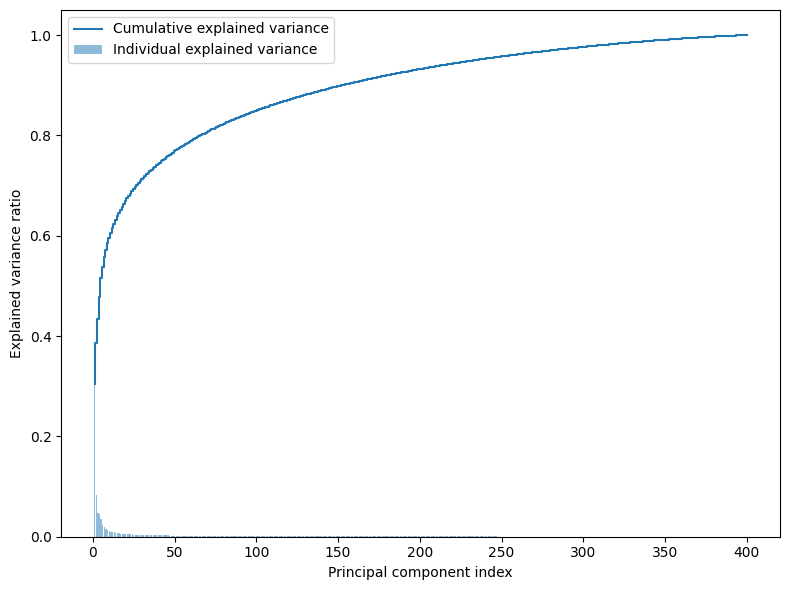

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming 'X_balanced' is your data matrix
# Here we're using a small random dataset as an example
# Replace this with: X_balanced = YOUR_DATA
# X_balanced = np.random.rand(100, 10)

pca = PCA()
pca.fit(X_balanced)

# Calculate the percentage of variance explained by each of the selected components
variance_explained = pca.explained_variance_ratio_

# Cumulative variance explained
cumulative_variance_explained = np.cumsum(variance_explained)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(variance_explained) + 1), variance_explained, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_explained) + 1), cumulative_variance_explained, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


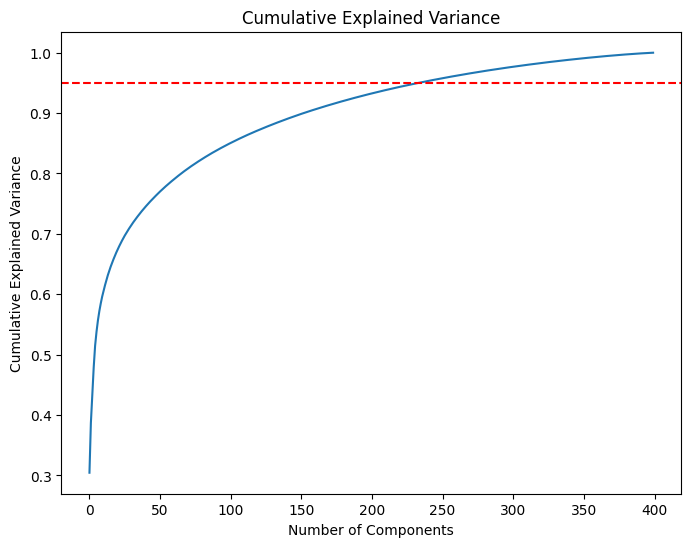

In [45]:
plt.figure(figsize=(8, 6))
plt.plot(cumulative_variance_explained)
plt.axhline(y=0.95, color='r', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Find the number of components that explain 95% variance
n_components_95 = np.where(cumulative_variance_explained >= 0.95)[0][0] + 1


In [46]:
np.where(cumulative_variance_explained > .95)

(array([233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
        246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
        259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271,
        272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284,
        285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297,
        298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310,
        311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323,
        324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336,
        337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349,
        350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362,
        363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375,
        376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388,
        389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399]),)

## visualize the top 10 components (incorrect?)
plot the weights of the top 10 PCs projected back to brain

Wouldn't I have to do this differently for each class?

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown

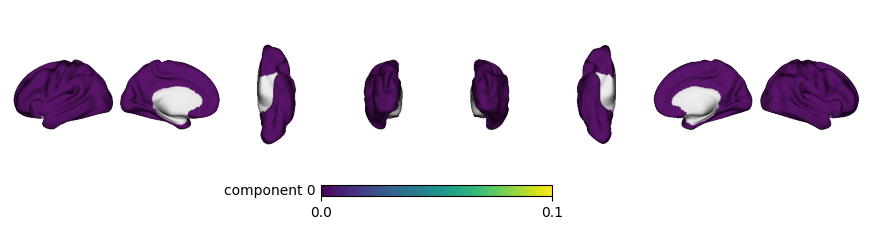

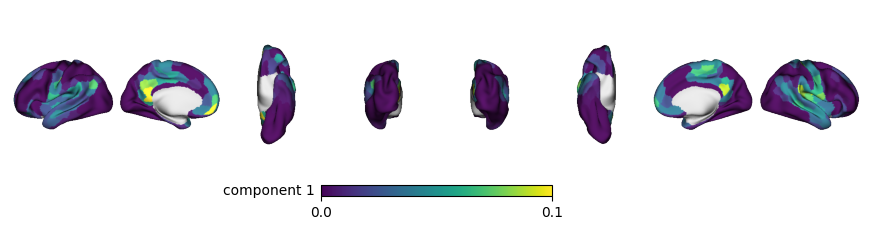

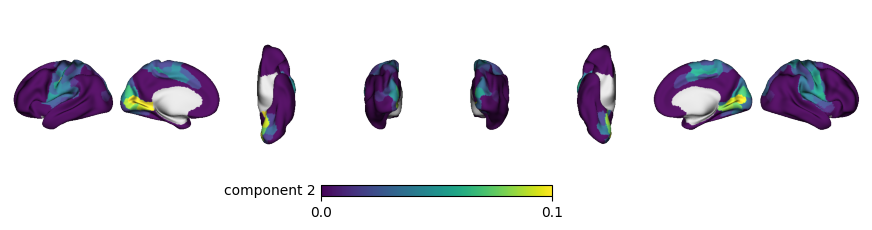

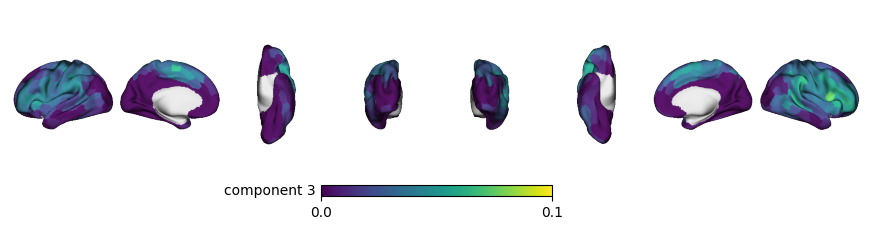

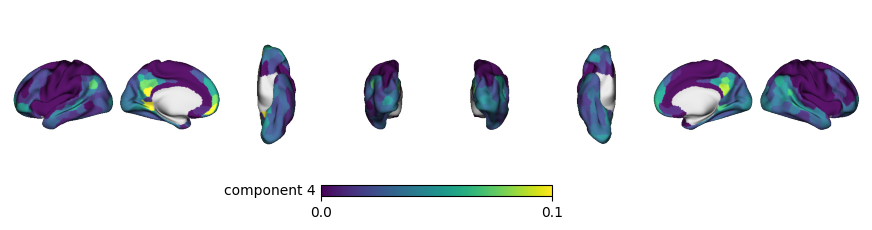

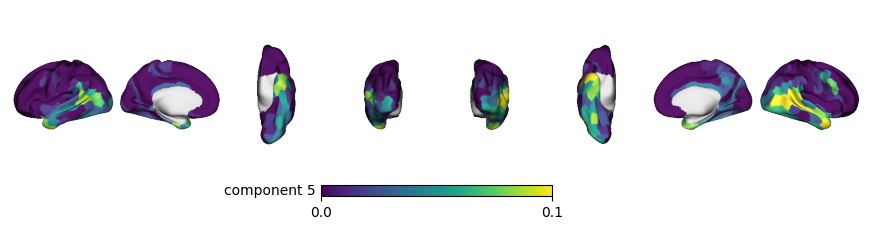

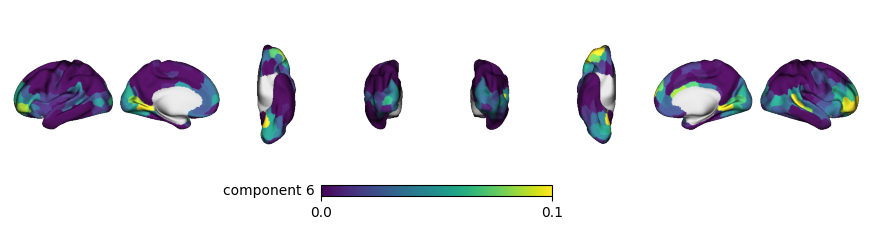

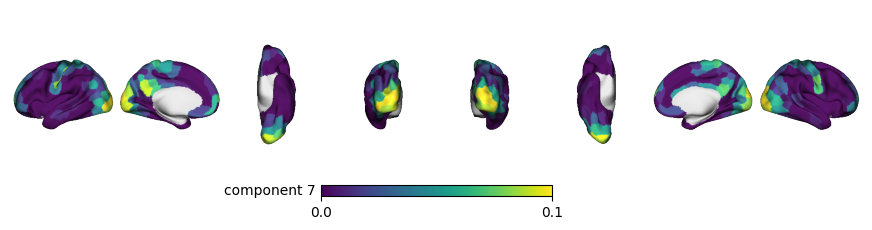

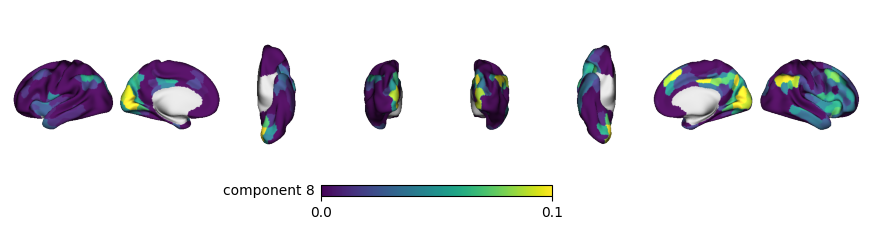

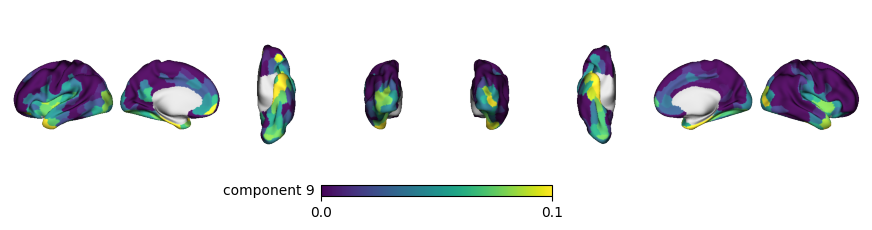

In [47]:
# Assuming you've already performed PCA as `pca = PCA(n_components=200).fit(X)`
# And you have a method to map the components back to brain space

for i in range(min(10, pca.n_components_)):  # Visualize the top 10 components
    component = pca.components_[i]
    # Convert the component to a brain map here if necessary
    
    comp = parc.inverse_transform(component)
    plot_brain_surfaces(image=comp, cbar_label=f'component {i}', cmap='viridis', color_range=(0,.1))



## SVM weights and PC

In [197]:
weights.size

400

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown

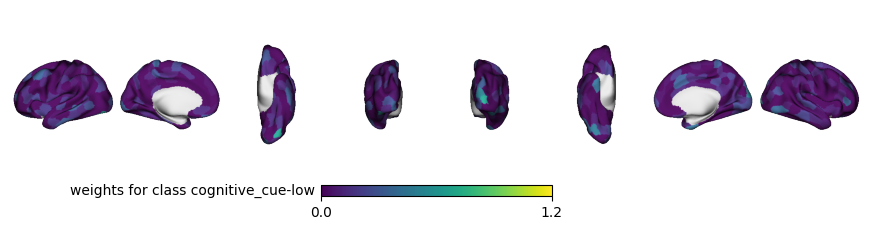

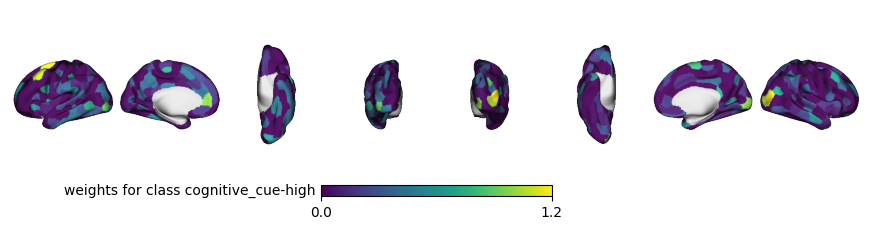

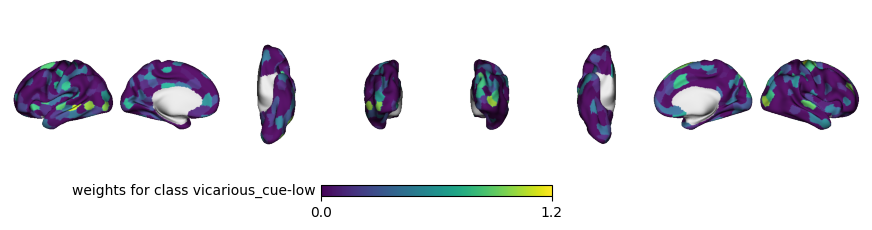

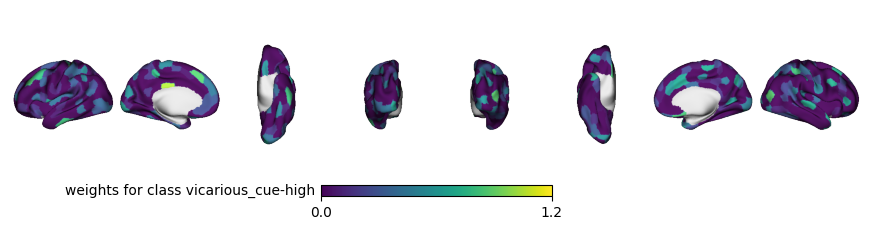

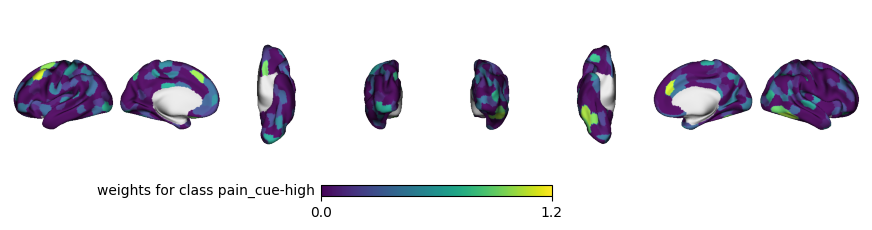

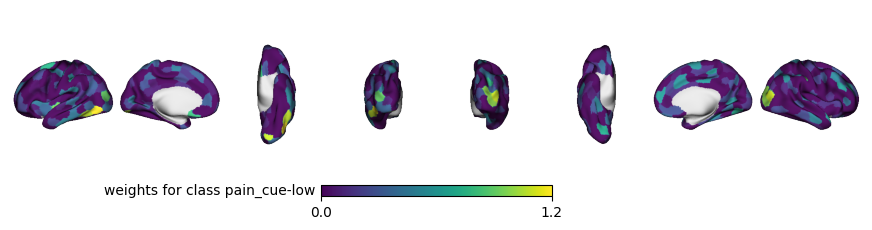

In [57]:
for i in range(len(svm.classes_)):  # There will be one set of weights per class
    weights = svm.coef_[i]

    comp = parc.inverse_transform(weights)
    plot_brain_surfaces(image=comp, cbar_label=f'weights for class {uniques[i]}', cmap='viridis', color_range=(0,1.2))


## plot PCs per class

After using three PCs, project the SVM weigths back into the PCA components.
which components are imporant for classification

## extract PC components per class (pain vicarios cognitive)
Then project the weights back to the extracted PCs

0
1


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


2
3


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


4


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


5


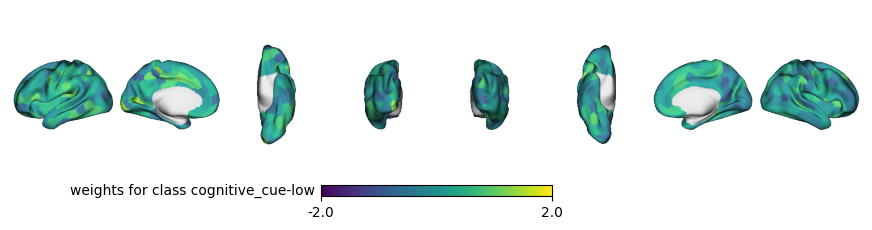

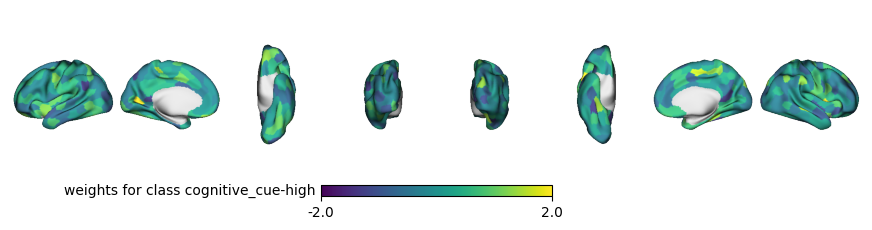

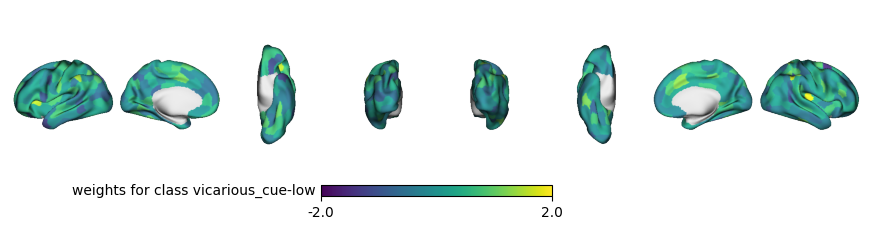

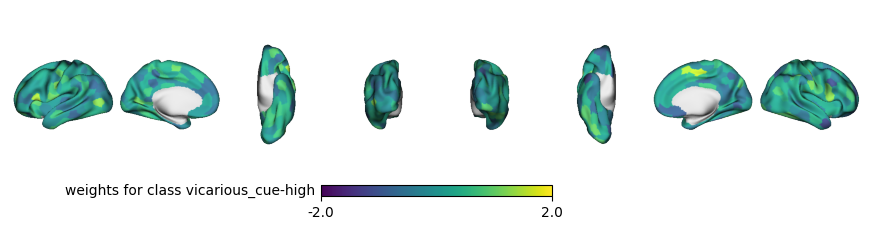

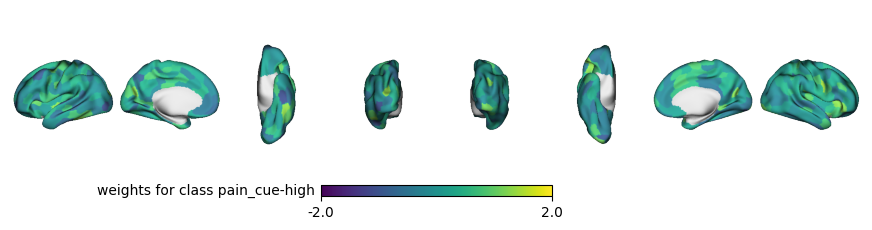

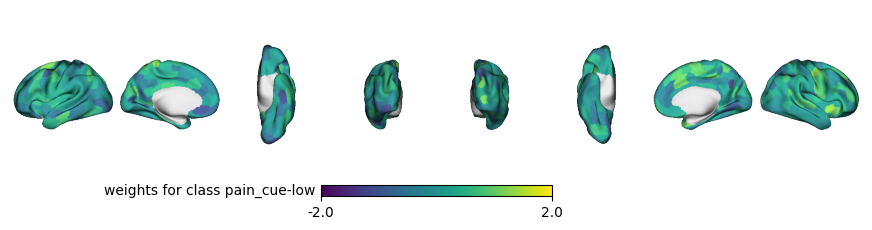

In [48]:
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Initialize a dictionary to hold the PCA models for each class
class_pca_models = {}
class_pca_components = {}


# Iterate over each class to create separate PCA models
for class_label in np.unique(Y_balanced):
    # Extract samples for the current class
    X_class = X_balanced[Y_balanced == class_label]
    
    # Create and fit PCA model for the current class
    pca = PCA()
    pca.fit(X_class)
    
    # Store the PCA model and the components
    class_pca_models[class_label] = pca
    class_pca_components[class_label] = pca.components_
for class_label in np.unique(Y_balanced):
    print(class_label)
    # Extract the weights for the current class from the SVM model
    svm_weights = svm.coef_[class_label]
    
    # Project the SVM weights back onto the original space using the PCA model for the current class
    original_space_weights = class_pca_models[class_label].inverse_transform(svm_weights)
    weights_original_space = pca.inverse_transform(original_space_weights)
    comp = parc.inverse_transform(weights_original_space)
    plot_brain_surfaces(image=comp, cbar_label=f'weights for class {uniques[class_label]}', cmap='viridis', color_range=(-2, 2))




5
4


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


2
3


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


0
1


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_15710/639931005.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


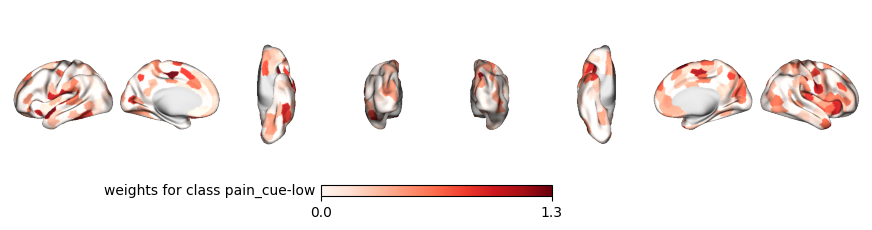

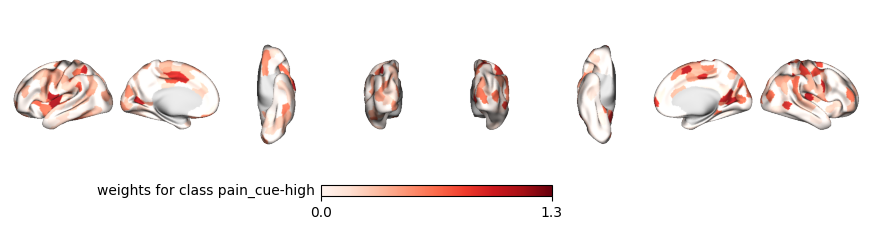

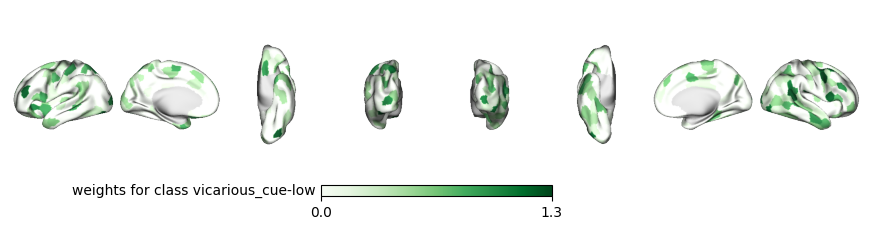

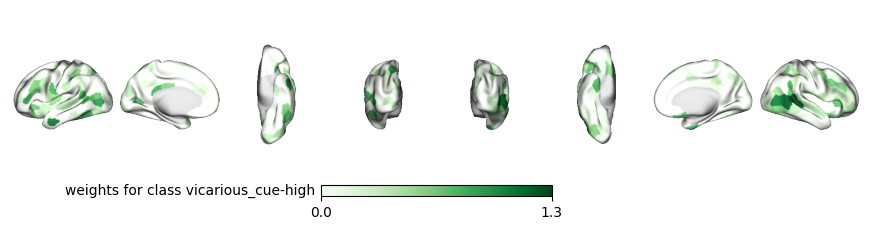

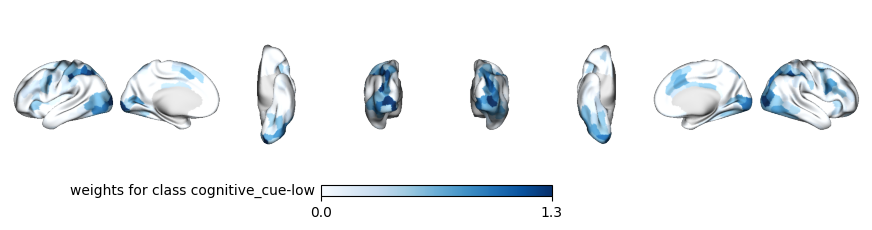

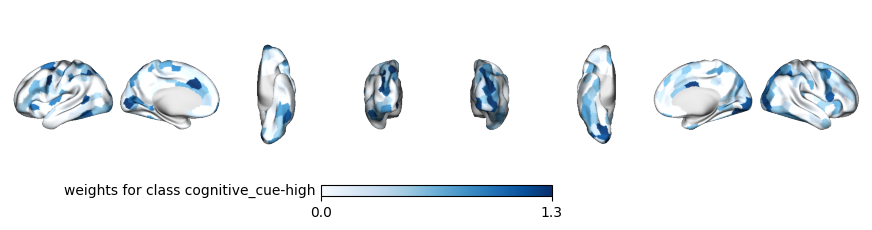

In [50]:
# Define the desired order explicitly
def select_cmap(label):
    if 'pain_cue' in label:
        return 'Reds'
    elif 'cognitive_cue' in label:
        return 'Blues'
    else:
        return 'Greens'
desired_order = ['pain_cue-low', 'pain_cue-high',
                       'vicarious_cue-low','vicarious_cue-high',
                       'cognitive_cue-low', 'cognitive_cue-high'
                        ]
# Map each unique class label to its index in the desired order
order_mapping = {label: i for i, label in enumerate(desired_order)}

# Now sort the unique class labels in Y_balanced according to the desired order
sorted_class_labels = sorted(np.unique(Y_balanced), key=lambda label: order_mapping[uniques[label]])

# Now iterate over the sorted class labels
for class_label in sorted_class_labels:
    print(class_label)
    # Your existing logic here...
    svm_weights = svm.coef_[class_label]
    original_space_weights = class_pca_models[class_label].inverse_transform(svm_weights)
    comp = parc.inverse_transform(original_space_weights)

    # Determine cmap based on class label
    cmap = select_cmap(uniques[class_label])
    
    # Plot with the selected cmap
    plot_brain_surfaces(image=comp, cbar_label=f'weights for class {uniques[class_label]}', cmap=cmap, color_range=(0, 1.3))
